In [ ]:
!pip install dask
!pip install wordcloud
!pip install spacy
!python -m spacy download es_core_news_sm

from IPython.display import clear_output
clear_output()
print('Dask installed.')
print('WordCloud installed.')
print('Spacy es_core_news_model installed.\nRestart the runtime!')

Go to Restart runtime...

In [1]:
import base64
from collections import Counter, OrderedDict
import json
import math
import os
import re
from string import Template
import time
from typing import List, Optional, Dict, Tuple, Iterable, Any

import requests
import dask
from dask import bag as db
from dask.delayed import delayed, Delayed
import numpy as np
from pandas import DataFrame
from PIL import Image
import spacy
from spacy.tokens import Token
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud

# Annotations
ElementList = List[Optional[Dict[str, Any]]]
Document = str
DocumentList = List[Document]
DocumentNormalizedList = List[DocumentList]
TermFrequency = Dict[str, float]
IDF = Dict[str, float]
TFIDF = Dict[str, float]
TFIDF_List = List[TFIDF]

CUBADEBATE_API = "http://www.cubadebate.cu/wp-json/wp/v2/"
COMMENTS_ENDPOINT = CUBADEBATE_API + "comments/"
SEARCH_ENDPOINT = CUBADEBATE_API + "search/"

session = requests.Session()
ConnectionErrorRequests = requests.exceptions.ConnectionError


@delayed
def get_elements_json(url: str, **kwargs) -> ElementList:
    """Get JSON of list elements from endpoint API Wordpress v2

    RETURNS (ElementList): Delayed Response List of elements in JSON format
    to compute for Dask.Bag
    """
    params = {"page": '1'}
    params.update(kwargs)
    results = []

    try:
        with session:
            time.sleep(1)
            resp = session.get(url, params=params)
            if resp.status_code == 200:
                results = resp.json()
                return results
    except ConnectionErrorRequests:
        pass  # Try again! Occurred Connection Error
    return results


def get_comments(pages: int) -> List[str]:
    """Get List of comments per page"""
    comments_delayed = (get_elements_json(url=COMMENTS_ENDPOINT, page=str(page))
                        for page in range(1, pages + 1))

    comments_bag = db.from_delayed(comments_delayed).map(lambda d: d['content']['rendered'])
    # In Windows the Dask.Bag is multiprocessing by default, change to threads
    with dask.config.set(scheduler='threads'):
        comments: List[str] = comments_bag.compute()
    return comments


def get_searches(words: List[str]) -> List[Dict[str, Any]]:
    """Get List of searches one page"""
    search_delayed = (get_elements_json(url=SEARCH_ENDPOINT, search=word)
                      for word in words)

    searches_bag = db.from_delayed(search_delayed)
    with dask.config.set(scheduler='threads'):
        searches = searches_bag.compute()
    return searches


_start = time.time()
comments_list = get_comments(pages=1)
_end = time.time()
print(f'{len(comments_list)} Comments downloaded in {(_end - _start):.2f}s')
# comments_list

0 Comments downloaded in 368.47s


In [2]:
NUM_PAGES = 100

_start = time.time()
corpus = get_comments(pages=NUM_PAGES)
_end = time.time()
print(f'{len(corpus)} Comments downloaded in {(_end - _start):.2f}s')
# corpus

1000 Comments downloaded in 403.88s


In [3]:
# Load model
nlp = spacy.load('es_core_news_sm')
bow_lemma_token = dict()


def remplace_accents(text: str) -> str:
    """Remplace spanish accents vocab lower case: Unicode code point literal to str"""
    text = re.sub(r'á', 'a', text, flags=re.I)
    text = re.sub(r'é', 'e', text, flags=re.I)
    text = re.sub(r'í', 'i', text, flags=re.I)
    text = re.sub(r'ó', 'o', text, flags=re.I)
    text = re.sub(r'ú', 'u', text, flags=re.I)
    return text


def get_text(markup: str) -> str:
    """Remove html tags, URLs and spaces using regexp"""
    text = re.sub(r'<.*?>', '', markup)
    url_pattern = r'(http|ftp)s?://(?:[a-zA-Z]|[0-9]|[$-_@.&#+]|[!*\(\),]|\
                   (?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_pattern, '', text)
    text = re.sub(r'\s+', " ", text)
    return text.strip()


def preprocess_token(token: Token) -> str:
        """Remove grave accents and return lemmatized token lower case"""
        result = remplace_accents(token.lemma_.strip().lower())
        return result


def is_token_allowed(token: Token) -> bool:
        """No Stop words, No Punctuations or len token >= 3"""
        if (not token or not token.string.strip() or
                token.is_stop or token.is_punct or len(token) < 3):
            return False
        return True

    
@delayed
def clean(doc: str) -> List[str]:
    """Remove grave accents, stopwords, the punctuations and normalize the corpus."""
    text = get_text(doc)
    text = text.lower()
    tokens = []
    
    for token in nlp(text):
        if is_token_allowed(token):
            word_lemma = preprocess_token(token)
            bow_lemma_token[word_lemma] = token
            tokens.append(word_lemma)
            
    return tokens


def get_documents_delayed(documents: DocumentList) -> List[Delayed]:
    """Return List[Delayed] clean document"""
    results = []  # type: List[dask.delayed.Delayed]

    for document in documents:
        results.append(clean(document))

    return results


def get_documents_normalized(documents: DocumentList) -> DocumentNormalizedList:
    """Return DocumentNormalizedList clean document"""
    with dask.config.set(scheduler='threads'):
        docs_normalized = list(*dask.compute(get_documents_delayed(documents)))
    return docs_normalized


# Process corpus using Dask.delayed
_start = time.time()
documents_normalized = get_documents_normalized(corpus)
_end = time.time()
print(f'{len(documents_normalized)} Documents normalized in {(_end - _start):.2f}s')

1000 Documents normalized in 469.33s


In [4]:
# TF-IDF
def comment_tf(document: DocumentList) -> TermFrequency:
    """Term Frequency for a document"""
    bow = Counter(document)
    tf_dict = dict()

    for k, v in bow.most_common():
        tf_dict[k] = v / len(document)

    return tf_dict


def comments_tf(documents: DocumentNormalizedList) -> List[TermFrequency]:
    """Term Frequency for many document"""
    return [comment_tf(comment)
            for comment in documents]


def count_dict(documents: DocumentNormalizedList) -> Dict[str, int]:
    """Counter the word in all documents at least ones"""
    counts = dict()
    for document in documents:
        uniq_words = set(document)
        for word in uniq_words:
            _value = counts.get(word, 0)
            counts[word] = _value + 1
    return counts


def idf_dict(documents: DocumentNormalizedList) -> IDF:
    """Inverse Document Frequency in all Documents"""
    idf_d = dict()

    counts = count_dict(documents)

    for word in counts:
        idf_d[word] = math.log(len(documents) / counts[word])

    return idf_d


def comments_tfidf(documents: DocumentNormalizedList) -> TFIDF_List:
    """TF-IDF of all Documents Normalized"""
    tfidf_comments = []

    idf_comments = idf_dict(documents)

    def compute_tfidf_comment(document: DocumentList) -> TFIDF:
        """Compute TF-IDF for a Document"""
        tfidf_comment = dict()

        tf_comment = comment_tf(document)

        for word in set(document):
            tfidf_comment[word] = tf_comment[word] * idf_comments[word]

        return tfidf_comment

    for comment in documents:
        tfidf_comments.append(compute_tfidf_comment(comment))

    return tfidf_comments


tfidf_list = comments_tfidf(documents_normalized)
# tfidf_list
print('TF-IDF comments list')

TF-IDF comments list


In [5]:
unordered_tfidf: Dict[str, float] = dict()

for tfidf in tfidf_list:
    for w, value in tfidf.items():
        if w in unordered_tfidf:
            unordered_tfidf[w] += value
        else:
            unordered_tfidf[w] = value


def sort_tfidf(tfidf_unordered) -> Iterable[Tuple[Any, Any]]:
    return sorted(tfidf_unordered.items(), key=lambda x: x[1], reverse=True)


# unordered_tfidf
ordered_comments_tfidf = OrderedDict(sort_tfidf(unordered_tfidf))

#WordCloud with word_token
token_comments_tfidf = dict()

for lemma_, value in ordered_comments_tfidf.items():
    _token = str(bow_lemma_token[lemma_])
    token_comments_tfidf[_token] = value

# Save to JSON file
with open('comments_tfidf.json', 'w') as file_json:
    json.dump(token_comments_tfidf, file_json)
print('TF-IDF ordered saved to comments_tfidf.json')

TF-IDF ordered saved to comments_tfidf.json


In [6]:
# Capitolio Habana
IMG_CAPITOLIO = os.getenv("IMG_CAPITOLIO") or "capitolio.jpg"

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
_dir = os.path.dirname(__file__) if "__file__" in locals() else os.getcwd()

IMG_CAPITOLIO: str = os.path.join(_dir, IMG_CAPITOLIO)
IMG_CAPITOLIO_LINK: str = 'https://upload.wikimedia.org/wikipedia/commons/8/8f/Capitolio_full.jpg'

# download mask images
# !wget http://media.cubadebate.cu/wp-content/gallery/la-habana-nocturna/app_la-habana_05.jpg -O la_hababa.jpg
if not os.path.isfile(IMG_CAPITOLIO):
    response = requests.get(IMG_CAPITOLIO_LINK)

    if response.status_code == 200:
        with open(IMG_CAPITOLIO, 'wb') as _capitolio:
            _capitolio.write(response.content)
            print('Image downloaded.')
    else:
        print('Image No downloaded!')
else:
    image_downloaded: str = IMG_CAPITOLIO.split("\\")[-1].split("/")[-1]
    print(f"Image: {image_downloaded}")

Image: capitolio.jpg


WordCloud Cubadebate image saved.


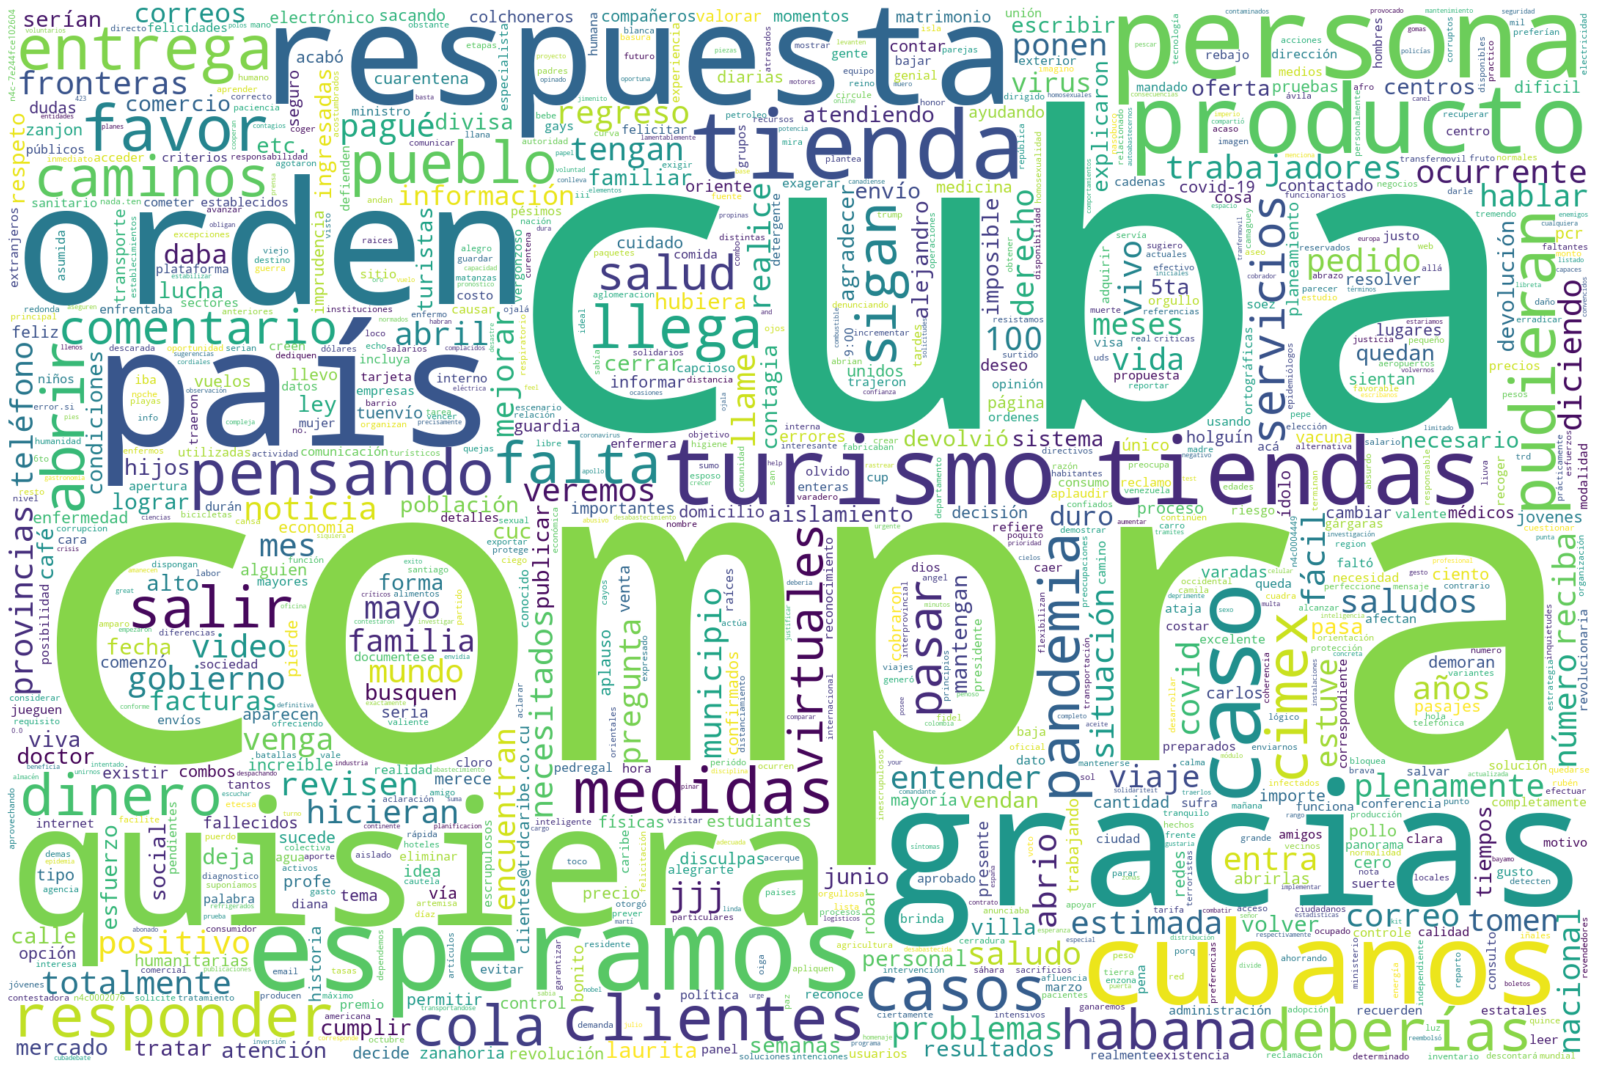

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# WordsCloud Cubadebate
IMG_WORDCLOUD = 'wordcloud_cubadebate.png'

# read the mask image
_mask = np.array(Image.open(IMG_CAPITOLIO))

# Generate Word Cloud
wordcloud = WordCloud(
    max_words=1000,
    #     max_font_size=50,
    height=1440,
    width=2160,
    background_color='white',
    mask=_mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords=STOP_WORDS).generate_from_frequencies(token_comments_tfidf)
# Save to file
wordcloud.to_file(IMG_WORDCLOUD)
print('WordCloud Cubadebate image saved.')
fig = plt.figure(figsize = (22, 15),)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
def export_image2html(image_name: str) -> None:
    """Export a image to html file"""
    with open(image_name, 'rb') as file_img:
        data = base64.b64encode(file_img.read()).decode('utf-8')

    img_str = '''
    <img width="100%" height="100%" 
    src="data:image/png;base64,{}" />
    '''.format(data)

    with open('wordcloud_cubadebate.html', 'w') as _html:
        _html.write(img_str)


# export_image2html(IMG_WORDCLOUD)
# print('Exported image to html.')

In [9]:
# Get Words (Tokens) with most TF-IDF
df = DataFrame.from_dict(data=token_comments_tfidf, dtype=int,
                         orient='index', columns=['TF-IDF']). \
    reset_index().rename(index=str, columns={'index': 'Word'})
rows, columns = df.shape
print(f'Panda DataFrame shape:({rows}, {columns})')

df_gb = df.groupby(['TF-IDF'], sort=False).first().reset_index()
rows, columns = df_gb.shape
print(f'GroupBy DataFrame shape:({rows}, {columns})\n')
print(df_gb)

words_token = list(df_gb['Word'].values)
searches_dict = dict()
searches_ids = set()

for w_token in words_token:
    search_list = get_searches([w_token])
    # Get first searched result
    if len(search_list) > 0:
        search_id = search_list[0]['id']
        if not search_id in searches_ids:
            searches_ids.add(search_id)
            searches_dict[w_token] = search_list[0]

# DataFrame First Search Posts
if len(searches_dict) > 0:
    searches_df = DataFrame.from_dict(data=searches_dict, orient='index', ) \
        .drop(columns=['type', 'subtype', '_links'])
    
    df_dates = searches_df['url'].str.extract('(?P<date>\d{4}/\d{2}/\d{2})')

    searches_by_dates = searches_df.join(df_dates).sort_values(by='date', ascending=False)

    print('\nTop Word Token and Post\n')
    print(searches_by_dates)
    searches_by_dates.to_json(os.path.join(_dir, 'top_word_post.json'))
    print('\nSaved top_word_post.json\n')

    with open('index.html', 'w', encoding='utf-8') as f_index, open('index.tpl', 'r') as file:
        tpl = file.read()
        index_template = Template(tpl)
        
        text_link = "<ul>\n"
        for _index, _title, _url in searches_by_dates.reset_index()[['index', 'title', 'url']].values:
            text_link += f"\t<li><a href='{_url}' rel='external' data-token='{_index}'>{_title}</a></li>\n"
        text_link += "</ul>"
        # Create index.html from index.tpl
        f_index.write(index_template.substitute(CUBADEBATE_LINKS=text_link))

    print('Rewrite index.html.\n')


Panda DataFrame shape:(6352, 2)
GroupBy DataFrame shape:(15, 2)

    TF-IDF           Word
0       15         compra
1       13       quisiera
2       12          orden
3       11        persona
4       10        turismo
5        9          casos
6        8          cimex
7        7          sigan
8        6         pedido
9        5       diciendo
10       4        correos
11       3       esfuerzo
12       2  completamente
13       1       acciones
14       0       insinuar

Top Word Token and Post

                    id                                              title  \
casos          1368073  Cuba reporta 22 casos positivos a la COVID-19,...   
turismo        1367727  Ministerio del Turismo: Cuba no reabrirá aún s...   
acciones       1367605  Acciones para prevenir y disminuir contagios c...   
persona        1365763  COVID-19 en el mundo: Los contagiados con el n...   
insinuar       1365581         Desde Casa con Abel Prieto (Primera Parte)   
cimex          1364169  CIMEX i